In [1]:
import json

with open("batch.jsonl") as f:
    inputs = [json.loads(line) for line in f]

with open("result.jsonl") as f:
    outputs = [json.loads(line) for line in f]


In [2]:
inputs.sort(key=lambda e: e['custom_id'])
outputs.sort(key=lambda e: e['custom_id'])

In [3]:
data = []
for inp, out in zip(inputs, outputs):
    assert inp['custom_id'] == out['custom_id']
    data.append({
        "content": inp['body']['messages'][1]['content'],
        **json.loads(out['response']['body']['choices'][0]['message']['content'])
    })

In [4]:
import pandas

In [5]:
valid_key = ['content', 'companyName', 'jobTitle', 'jobLevel', 'yoe',
       'programmingLanguages', 'frameworks', 'skills', 'responsibilities',
       'problems', 'difficulty', 'topics']
def fix_data(example: dict)-> dict:
    def replace(dd: dict, key: str, replace:str):
        if key in dd:
            dd[replace] = dd[key]
            del dd[key]
        
    replace(example, "topic", "topics")
    replace(example, "interview_topics", "topics")
    replace(example, "interviewTopics", "topics")
    replace(example, "problemDifficulty", "difficulty")
    replace(example, "problemTag", "problems")
    replace(example, "problemTags", "problems")
    replace(example, "problem_tag", "problems")

    to_be_removed = []
    for k in example:
        if k not in valid_key:
            to_be_removed.append(k)
    for k in to_be_removed:
        del example[k]
    return example

for i in range(len(data)):
    data[i] = fix_data(data[i])

In [6]:
gg = pandas.DataFrame(data)

In [7]:
programming_languages = [
    "Ada",
    "ALGOL",
    "APL",
    "AppleScript",
    "Assembly",
    "AWK",
    "BASIC",
    "Batch",
    "C",
    "C++",
    "C#",
    "COBOL",
    "ColdFusion",
    "Common Lisp",
    "Crystal",
    "D",
    "Dart",
    "Delphi",
    "Eiffel",
    "Elixir",
    "Erlang",
    "F#",
    "Fortran",
    "Go",
    "Groovy",
    "Haskell",
    "HTML","CSS",
    "IDL",
    "Inform",
    "Java",
    "JavaScript",
    "Julia",
    "Kotlin",
    "LabVIEW",
    "Lisp",
    "Logo",
    "Lua",
    "MATLAB",
    "Mercury",
    "Modula-2",
    "Modula-3",
    "MUMPS",
    "Nim",
    "Objective-C",
    "OCaml",
    "Octave",
    "Pascal",
    "Perl",
    "PHP",
    "SQL",
    "PostScript",
    "Prolog",
    "Python",
    "R",
    "Rust",
    "SAS",
    "Scala",
    "Scheme",
    "SQL",
    "Swift",
    "Tcl",
    "TypeScript",
    "Vala",
    "VB.NET",
    "Visual Basic",
]

In [8]:
gg['companyName'] = gg['companyName'].fillna("")
gg['companyName'] = gg['companyName'].replace(['Unknown', 'N/A', 'Not specified', 'Not provided'], '')
gg['jobTitle'] = gg['jobTitle'].fillna("")
gg = gg.drop(gg[gg['jobTitle'] == ''].index)
gg['yoe'] = pandas.to_numeric(gg['yoe'], errors='coerce')
gg = gg.dropna(subset=['yoe'])
gg = gg.drop((gg[gg['programmingLanguages'].apply(bool).apply(lambda e: not e)]).index)
gg = gg.dropna(subset=['programmingLanguages'])
gg = gg.drop((gg[gg['responsibilities'].apply(bool).apply(lambda e: not e)]).index)
gg = gg.dropna(subset=['responsibilities'])

def filterProgrammingLang(val):
    for lang in val:
        if lang not in programming_languages:
            return False
    
    return True

gg = gg[gg['programmingLanguages'].apply(filterProgrammingLang)]
gg['jobLevel'] = gg['jobLevel'].replace(['mid', 'mid-level'], 'middle')
gg['jobLevel'] = gg['jobLevel'].replace(['middle_senior'], 'senior')
gg = gg.drop(gg[gg['jobLevel'] == 'junior to senior'].index)
gg = gg[gg['jobLevel'].apply(lambda e: not isinstance(e, list))]

In [9]:
import copy
import datasets

In [14]:
tt = gg.to_dict(orient='records') 

In [15]:
tt

[{'content': 'This is a job description of a job related to IT field:\n-----------------------------------\nThe Senior Developer works under minimal supervision and will develop, test, debug and document software components commensurate with their experience under the limited supervision of more senior development staff in support of a software engineering effort.\n\nReview and analyze complex process, system and/or data requirements and specifications.Serve as the primary designer for complex component designs for one or more areas (subsystems) of a project, product or program.Build, test, deploy, and document complex software components for one or more areas (subsystems) of a project, product, and/or program level solution.Assist in the creation of software engineering strategies that help identify and mitigate risks.Lead other team members in peer review of code.Interface with other team members and other teams in peer review of requirements, specifications and software.Document and

In [11]:
raise 0

TypeError: exceptions must derive from BaseException

In [16]:
finetune_data = []
for row in tt:
    tmp = copy.deepcopy(row)
    del tmp['content']
    finetune_data.append({
        "text_input": row['content'],
        "output": json.dumps(obj=tmp, ensure_ascii=False, indent=0)
    })

In [17]:
with open("finetune_data.jsonl", 'w') as f:
    for i in finetune_data:
        f.write(json.dumps(i) + '\n')

In [ ]:
# tt.push_to_hub("pre-view/JD-IT-extracted", private=True)

In [18]:
finetune_data[0]

{'text_input': 'This is a job description of a job related to IT field:\n-----------------------------------\nThe Senior Developer works under minimal supervision and will develop, test, debug and document software components commensurate with their experience under the limited supervision of more senior development staff in support of a software engineering effort.\n\nReview and analyze complex process, system and/or data requirements and specifications.Serve as the primary designer for complex component designs for one or more areas (subsystems) of a project, product or program.Build, test, deploy, and document complex software components for one or more areas (subsystems) of a project, product, and/or program level solution.Assist in the creation of software engineering strategies that help identify and mitigate risks.Lead other team members in peer review of code.Interface with other team members and other teams in peer review of requirements, specifications and software.Document a

In [19]:
import time
import google.generativeai as genai

base_model = "models/gemini-1.5-flash-001-tuning"
training_data = finetune_data
operation = genai.create_tuned_model(
    # You can use a tuned model here too. Set `source_model="tunedModels/..."`
    display_name="jd-extract2",
    source_model=base_model,
    epoch_count=20,
    batch_size=16,
    learning_rate=0.00001,
    training_data=training_data,
)

for status in operation.wait_bar():
    time.sleep(10)

result = operation.result()
print(result)
# # You can plot the loss curve with:
# snapshots = pd.DataFrame(result.tuning_task.snapshots)
# sns.lineplot(data=snapshots, x='epoch', y='mean_loss')

# model = genai.GenerativeModel(model_name=result.name)
# result = model.generate_content("III")
# print(result.text)  # IV
print(result)

  0%|          | 0/350 [00:00<?, ?it/s]

TunedModel(name='tunedModels/jdextract2-c6092xkeiw5x',
           source_model='models/gemini-1.5-flash-001-tuning',
           base_model='models/gemini-1.5-flash-001-tuning',
           display_name='jd-extract2',
           description='',
           temperature=1.0,
           top_p=0.95,
           top_k=64,
           state=<State.ACTIVE: 2>,
           create_time=datetime.datetime(2024, 11, 10, 10, 48, 17, 848634, tzinfo=datetime.timezone.utc),
           update_time=datetime.datetime(2024, 11, 10, 11, 20, 24, 694476, tzinfo=datetime.timezone.utc),
           tuning_task=TuningTask(start_time=datetime.datetime(2024, 11, 10, 10, 48, 18, 434900, tzinfo=datetime.timezone.utc),
                                  complete_time=datetime.datetime(2024, 11, 10, 11, 20, 24, 694476, tzinfo=datetime.timezone.utc),
                                  snapshots=[...],
                                  hyperparameters=Hyperparameters(epoch_count=20,
                                             

In [21]:
import pandas as pd
import seaborn as sns

     step   mean_loss                     compute_time  epoch
0       1  161.448290 2024-11-10 10:48:23.764975+00:00    NaN
1       2  160.608250 2024-11-10 10:48:28.640689+00:00    NaN
2       3  143.755250 2024-11-10 10:48:34.333576+00:00    NaN
3       4  156.016660 2024-11-10 10:48:40.202785+00:00    NaN
4       5  151.408700 2024-11-10 10:48:47.628466+00:00    NaN
..    ...         ...                              ...    ...
345   346   63.126907 2024-11-10 11:20:00.528239+00:00   19.0
346   347   73.204285 2024-11-10 11:20:05.350302+00:00   19.0
347   348   85.359170 2024-11-10 11:20:10.151116+00:00   19.0
348   349   85.682980 2024-11-10 11:20:14.941685+00:00   19.0
349   350   57.211437 2024-11-10 11:20:19.720510+00:00   20.0

[350 rows x 4 columns]


<Axes: xlabel='epoch', ylabel='mean_loss'>

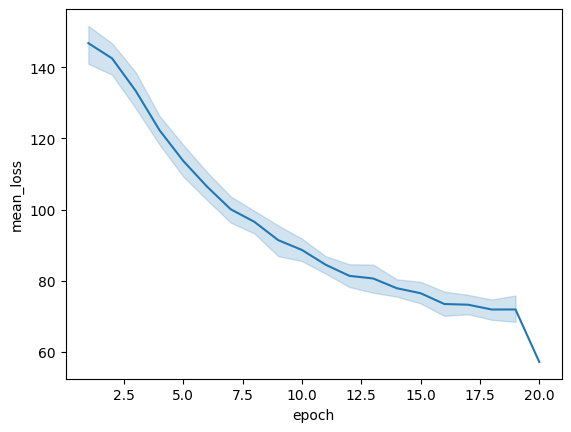

In [22]:
snapshots = pd.DataFrame(result.tuning_task.snapshots)
print(snapshots)
sns.lineplot(data=snapshots, x='epoch', y='mean_loss')

In [23]:
PROMT_TEMPLATE = """This is a job description of a job related to IT field:
-----------------------------------
{}
-----------------------------------
Your task is to extract the following information from the above paragraph and export it to valid json:
- Company name
- Job title
- Job level (intern, fresher, junior, senior)
- Year of experiences (yoe)
- Programming languages
- Frameworks
- Skills (technical skill only)
- Responisbilities
- Problem tag
- Problem difficulty
- Interview topics

Problem tag is the kind of problems the interviewer should ask the candidate, based on the job title, job level and experiences. All available task: Hash Table, Math, Two Pointers, Depth-First Search, Stack, Number Theory, Game Theory, Linked List, Tree, Dynamic Programming, Memoization, Reservoir Sampling, Trie, Set, Matrix, Greedy, Recursion, Graph, Bitmask, Union Find, Queue, Breadth-First Search, Divide and Conquer, Sorting, String, Backtracking, Binary Search, Array, Prefix Sum, Geometry, Shortest Path, Priority Queue, Sliding Window

Problem diffifulty is the difficulty of the questions to ask the candidate, this should based on the year of experiences and job level. It must be one of easy, medium, hard

Interview topics is the topic of questions the interviewer can use to ask the candidate

For example, with this job description:
-----------------------------------
Leader in the development and publishing of games, Gameloft® has established itself as a pioneer in the industry, creating innovative gaming experiences for over 20 years. Gameloft creates games for all digital platforms, from mobile to cross-platform titles for PC and consoles. Gameloft operates its own established franchises such as Asphalt®, Dragon Mania Legends, Modern Combat and Dungeon Hunter and also partners with major rights holders including LEGO®, Universal, Illumination Entertainment, Hasbro®, Fox Digital Entertainment, Mattel®, Lamborghini®, and Ferrari®. Gameloft distributes its games in over 100 countries and employs 2,700 people worldwide. Every month, 55 million unique users can be reached by advertisers in Gameloft games with Gameloft for brands, a leading B2B offering dedicated to brands and agencies. Gameloft is a Vivendi company. 

An Intern will learn and be trained
    C++ programming & OPP knowledge.
    Game features in Gameloft games.
    After the initial training period, the intern will join on-the-job training - work directly with the team on practical projects.
    Proposing ideas to contribute to the development of the team, department and studio in general.

Qualifications
    Final year students/fresh graduates from IT major; able to work full-time
    C++ programming & OOP knowledge
    Good logical thinking & willingness to learn
    Have a passion for programming, especially mobile game programming
    English proficiency is an advantage.
-----------------------------------

The output should be:
{{
    "companyName": "Gameloft",
    "jobTitle": "Game developer",
    "jobLevel": "intern",
    "yoe": 0
    "programmingLanguages": ["C++"],
    "frameworks": []
    "skills": [
        "Object Oriented Programming",
        "Logical thinking",
        "Willingness to learn",
        "Mobile game programming"
    ],
    "responsibilities": [
        "Contribute to the development of the team",
    ],
    "problems": ["Stack", "Hash table", "Array"],
    "difficulty": "easy"
    "topics": ["OOP", "C++", "Object lifetime"]
}}
"""

In [25]:
model = genai.GenerativeModel(model_name=result.name)
gen_res = model.generate_content(PROMT_TEMPLATE.format("""

Mô tả công việc

- Tham gia nghiên cứu/phát triển/nâng cấp các sản phẩm/giải pháp chuyển đổi số của công ty, ...

- Nghiên cứu và áp dụng các công nghệ mới vào dự án

- Các công việc khác theo sự phân công của Quản lý dự án.
Yêu cầu ứng viên

- Tốt nghiệp chuyên ngành công nghệ thông tin, kỹ thuật phần mềm, ....

- Tối thiểu 2 năm kinh nghiệm phát triển trên nền tảng .NET Framework/.NET Core;

- Thành thạo ASP.NET, MVC, Web API, Entity Framework;

- Sử dụng thành thạo HTML, Javascript.

"""))

print(gen_res.text)

```json
{
"companyName": "",
"jobTitle": "Software Developer",
"jobLevel": "junior",
"yoe": 2.0,
"programmingLanguages": [
"C#"
],
"frameworks": [
".NET Framework",
".NET Core",
"ASP.NET",
"ASP.NET MVC",
"ASP.NET Web API",
"Entity Framework"
],
"skills": [
"HTML",
"JavaScript"
],
"responsibilities": [
"Research, develop, and upgrade digital transformation products and solutions",
"Research and apply new technologies to projects",
"Perform other duties as assigned by the Project Manager"
],
"problems": [
"Array",
"String",
"Recursion",
"Graph"
],
"difficulty": "medium",
"topics": [
"C#",
".NET",
"Web development",
"Entity Framework"
]
}
```
